# Forward modelling the TIP

This notebook describes the creation of a synthetic dataset of VIS & NIR albedos that will be used for testing the `eoldas_ng` machinery.

The following parameters are set as in Bernard's prior, for simplicity (mixed leaves, I guess):

* $\omega_{VIS}$: 0.1700
* $d_{VIS}$: 1
* $a_{VIS}$: 0.1
* $\omega_{NIR}$: 0.7
* $d_{NIR}$: 2
* $a_{NIR}$: 0.18

We use my tried & tested double logistic for LAI..


In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from TwoSInterface import twostream_solver

def two_stream_model ( x, sun_angle, ucl_params=False ):
    """This function calculates absorption in the visible and NIR
    for a given parameter vector x.

    The parameter vector is:
    1. $\omega_{leaf,VIS}$
    2. $d_{leaf, VIS}$
    3. $r_{soil, VIS}$
    4. $\omega_{leaf,NIR}$
    5. $d_{leaf, NIR}$
    6. $r_{soil, NIR}$
    7. $LAI$
    
    """
    from TwoSInterface import twostream_solver
    #if np.any ( x[:-1] > 1.) or np.any ( x <= 0.01) \
    #         or ( x[-1] > 10):
    #    return  [ -1, -1]
    # These structural effective parameters are hardwired to be 1
    structure_factor_zeta = 1.
    structure_factor_zetastar = 1.
    # Calculate leaf properties in VIS and NIR
    # This first version of calculating refl & trans uses a slightly different
    # formulation to Bernard's. This ought to help with the priors
    # For the time being it's switched off
    if ucl_params:
        tvis = x[0]*x[1]
        rvis = x[0] - tvis
        tnir = x[3]*x[4]
        rnir = x[3] - tnir
    else:
        ####################### Pinty et al, 2008 VERSION ###########################################
        # Transmittance is single scattering albedo divided by (1+asymmetry)
        tvis = x[0]/(1.+x[1])
        rvis = x[1]*x[0]/(1+x[1])
        tnir = x[3]/(1.+x[4])
        rnir = x[4]*x[3]/(1+x[4])


    # Model visible
    ( collim_alb_tot_vis, collim_tran_tot_vis, collim_abs_tot_vis, 
        iso_alb_tot_vis, iso_tran_tot_vis, iso_abs_tot_vis ) = twostream_solver( 
        rvis, tvis, x[2], x[6], 
        structure_factor_zeta, structure_factor_zetastar, sun_angle )
    # Model NIR
    collim_alb_tot_nir, collim_tran_tot_nir, collim_abs_tot_nir, \
        iso_alb_tot_nir, iso_tran_tot_nir, iso_abs_tot_nir = \
        twostream_solver( rnir, tnir, x[5], x[6], \
        structure_factor_zeta, structure_factor_zetastar, \
        sun_angle )
    # For fapar we return 
    #[ iso_abs_tot_vis, iso_abs_tot_nir]
    return  [ collim_alb_tot_vis, collim_alb_tot_nir ]


def dbl_logistic_model ( p, x ):
    """A double logistic model, as in Sobrino and Juliean, or Zhang et al"""
    return p[0] + p[1]* ( 1./(1+np.exp(p[2]*(365.*x-p[3]))) + \
                          1./(1+np.exp(p[4]*(365.*x-p[5])))  - 1 )



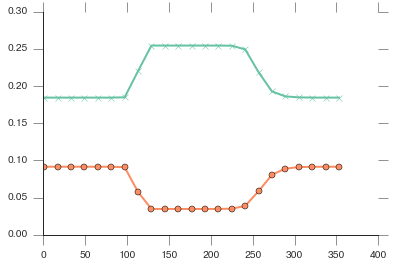

In [10]:
p = np.array([0.1, 5, -0.29, 120, 0.1, 240])
x= np.arange(1,366)/365.
#plt.plot(x, dbl_logistic_model(p,x) ,'-')
L = dbl_logistic_model(p,x)
albedo_vis = []
albedo_nir = []
doys = []
for i in np.arange(1,366,16):
    xx = np.array([0.17, 1., 0.1, 0.7, 2, 0.18, L[i]])
    doys.append ( i )
    av,an= two_stream_model ( xx, 30.)
    albedo_vis.append ( av )
    albedo_nir.append ( an )
doys = np.array ( doys )
albedo_vis = np.array(albedo_vis)
albedo_nir = np.array(albedo_nir)

plt.plot(doys, albedo_vis, 'o-')
plt.plot(doys, albedo_nir, 'x-')

In [14]:
np.savetxt("synthetic_albedo.txt", np.c_[doys, albedo_vis, albedo_nir], fmt="%0.4f", 
           header="DoY albedo_vis albedo_nir" )